
<p><a target ="_parent" href="https://colab.research.google.com/github/pjmartel/teaching/blob/master/enzymology/MMenten_analysis_pt.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a></p>


#### Estimativa de parâmetros cinéticos de enzimas Michaelianos por vários métodos

Este notebook implementa uma série de métodos de esimação dos
parâmetros Km e Vmax a partr de um conjunto de medidas de velocidade
inicial em função de concentração de substrato.

Métodos Implementados:

- Lineweaver-Burke
- Hanes-Woolfe
- Gráfico Linear Directo (Eisenthal-Cornish-Bowden)
- Non-Linear fitting (Johansen e Lumry, coeficiente de variação constante)
- Non-Linear fitting (Cornis-Bowden, variância constante)

#### Instruções de utilzação:

1. Na célula que têm como primeira linha "%%data", introduzir 
   os dados em colunas: primeira coluna concentrações, segunda
   e seguintes os replicados de velocidade
2. No barra de menu de topo, clickar em "Cell" e em seguida escolher
   "Run All"

In [130]:
# Import necessary modules
import numpy as np
import pandas as pd
import numpy.random as rnd
from scipy.stats import linregress
import matplotlib.pyplot as plt
from matplotlib import style,rcParams
from seaborn import regplot
from scipy.stats import linregress
from io import BytesIO, StringIO
style.use('default')
rcParams.update({'axes.grid': True})
rcParams.update({'errorbar.capsize': 2})
pd.options.display.float_format = '{:,.3g}'.format

In [131]:
# Michaelis-Menten equation
def MM(K,V,s):
  return V*s/(K+s)

In [132]:
#@title Carregue em "Play"
# This creates the "data" cell magic to allow for pasted
# values to be grabbed by the running cells. That's a good
# alternative to qgrid, not yet supported by colab.
from IPython.core.magic import  (
    Magics, magics_class, cell_magic, line_magic
)

@magics_class
class StoreData(Magics):


    def __init__(self, shell=None,  **kwargs):
        super().__init__(shell=shell, **kwargs)
        self._store = []
        # inject our store in user availlable namespace under __mystore
        # name
        shell.user_ns['__mystore'] = self._store

    @cell_magic
    def data(self, line, cell):
        """store the cell in the store"""
        self._store.append(cell)

    @line_magic
    def showdata(self, line):
        """show all recorded statements"""
        print(self._store)

    @line_magic
    def erasedata(self, line):
      "clear the shore"
      self._store = []

## use ipython load_ext mechanisme here if distributed
get_ipython().register_magics(StoreData)

In [133]:
%%data
1.000e-01 1.783e-01
3.000e-01 3.746e-01
5.000e-01 4.851e-01
7.000e-01 5.894e-01
9.000e-01 6.344e-01
1.100e+00 6.990e-01
1.300e+00 7.142e-01
1.500e+00 7.589e-01
1.700e+00 7.556e-01
1.900e+00 7.865e-01

In [134]:
#@title Carregue no botão "Play" para visualizar os dados introduzidos

# convert ',' decimal separator to '.'
def conv(x):
    return x.replace(',', '.').encode()

# read the above cell into a numpy array
data_np = np.genfromtxt(conv(x) for x in  StringIO(__mystore[-1])  )

# create an empy pandas data frame with the
# npoint lines and nrepl+1 columns
#
npoints = data_np.shape[0]
nrepl = data_np.shape[1]-1
columns = ['[A]']
columns = columns + ['v'+str(i+1) for i in range(nrepl)]
enz_data = pd.DataFrame(data_np,columns=columns)
if nrepl > 1:
  enz_data['Mean v']=enz_data.iloc[:,1:].mean(axis=1)
  enz_data['Std v']=enz_data.iloc[:,1:-1].std(axis=1)
enz_data

,[A],v1
0,0.1,0.178
1,0.3,0.375
2,0.5,0.485
3,0.7,0.589
4,0.9,0.634
5,1.1,0.699
6,1.3,0.714
7,1.5,0.759
8,1.7,0.756
9,1.9,0.786


In [135]:
# Get concentrations and velocities from the dataframe
if nrepl > 1 :
  v = np.array(enz_data.iloc[:,1:-2])
else:
  v = np.array(enz_data.iloc[:,1:])
s = np.array(enz_data['[A]'])

# Use the mean of replicates
vm = v.mean(axis=1) 

In [136]:
# Create a pandas dataframa for storing the various estimates
df_estimates = pd.DataFrame(np.zeros((2,5)),index = ['Km','Vmax'],columns=['L-B','H-W','E-CB','JL', 'CB'])
#df_estimates

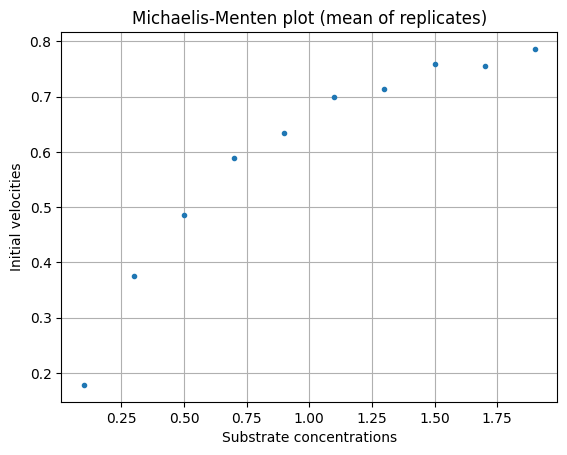

In [137]:
#### Untransformed data with replicates
plt.title("Michaelis-Menten plot (mean of replicates)")
plt.xlabel("Substrate concentrations")
plt.ylabel("Initial velocities")
#plt.ylim(0,1.1*Vmax)
plt.plot(s,vm,'.');

In [138]:
# Michaelis-Menten direct plot with error bars
if nrepl > 1:
    plt.plot(s,v,'r.',ms=3.3)
    plt.errorbar(s,v.mean(axis=1),fmt='g.',xerr=0.0,yerr=v.std(axis=1),capsize=2)
    plt.title("Michaelis-Menten Plot with error bars")


Lineweaver-Burke estimates:
    Km = 0.434, Vmax= 0.946, R2 = 0.9987



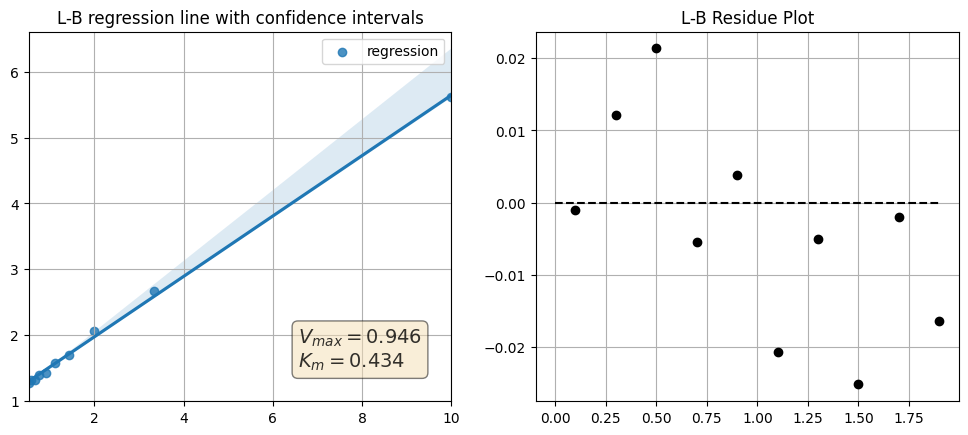

In [139]:
# Lineweaver-Burke regression with confidence intervals
vlb = v[:,0]
vlb = v.mean(axis=1)
fig = plt.figure()
fig.set_figwidth(12)
#fig.set_figheight(10)
plt.subplot(121)
regplot(1/s,1/vlb,label="regression")
m, b,r,_,_ = linregress(1/s,1/vlb)
_ = plt.title("L-B regression line with confidence intervals")
plt.legend()
# Place a box with the estimates
textstr = '\n'.join((
    r'$V_{max}=%.3g$' % (LB_Vmax, ),
    r'$K_m=%.3g$' % (LB_Km, ))) 
    #r'$\sigma=%.2f$' % (sigma, ))))
# place a text box in lower left in axes coords
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.35, 0.15, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props,alpha=0.8)

##
LB_Km = m/b
LB_Vmax = 1/b
v_hat = MM(LB_Km, LB_Vmax,s)
plt.subplot(122)
_ = plt.title("L-B Residue Plot")
_ = plt.hlines(0,0, s[-1],linestyles='dashed')
plt.plot(s,v_hat-vm,'ko')
plt.plot()
print()
print("Lineweaver-Burke estimates:")
print("    Km = {:5.3f}, Vmax= {:5.3f}, R2 = {:.4f}".format(LB_Km,LB_Vmax,r*r))
print()
df_estimates['L-B'] = LB_Km,LB_Vmax


Hanes-Woolf estimats:
    Km = 0.476, Vmax= 0.982, R = 0.9991



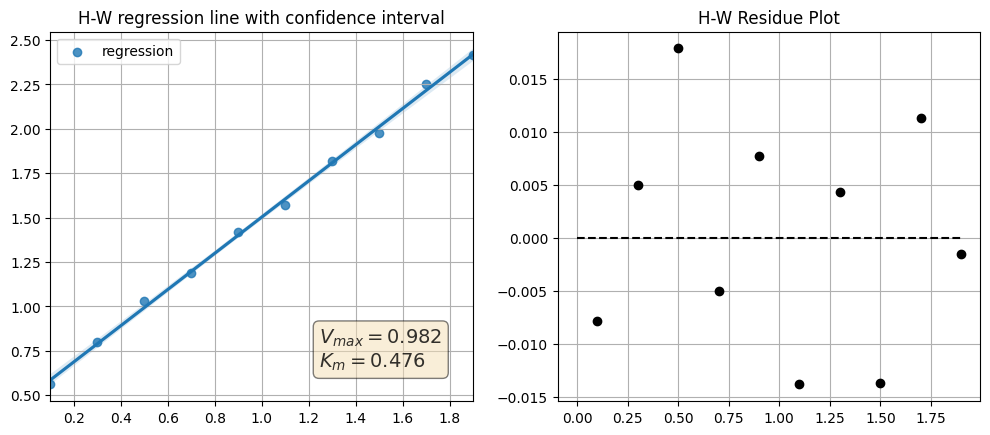

In [140]:
# Hanes-Woolf regression with confidence interval
shw = s
vhw = v.mean(axis=1)
#vhw = v[:,0]
vhw = s / vhw
fig = plt.figure()
fig.set_figwidth(12)
plt.subplot(121)
regplot(s,vhw,label="regression")
m, b,r,_,_ = linregress(s,vhw)
_ = plt.title("H-W regression line with confidence interval")
plt.legend()

# Place a box with the estimates
textstr = '\n'.join((
    r'$V_{max}=%.3g$' % (HW_Vmax, ),
    r'$K_m=%.3g$' % (HW_Km, ))) 
    #r'$\sigma=%.2f$' % (sigma, ))))
# place a text box in lower left in axes coords
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.40, 0.15, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props,alpha=0.8)


#print(m,b,r)
#print(1/m,b/m)
HW_Km = b/m
HW_Vmax = 1/m
v_hat = MM(HW_Km, HW_Vmax,s)
plt.subplot(122)
_ = plt.title("H-W Residue Plot")
_ = plt.hlines(0,0, s[-1],linestyles='dashed')
plt.plot(s,v_hat-vm,'ko')
print()
print("Hanes-Woolf estimats:")
print("    Km = {:5.3f}, Vmax= {:5.3f}, R = {:.4f}".format(HW_Km,HW_Vmax,r))
print()
df_estimates['H-W'] = HW_Km, HW_Vmax

Computing 45 intersections
Direct Linear plot estimates:
    Km = 0.474, Vmax= 0.984


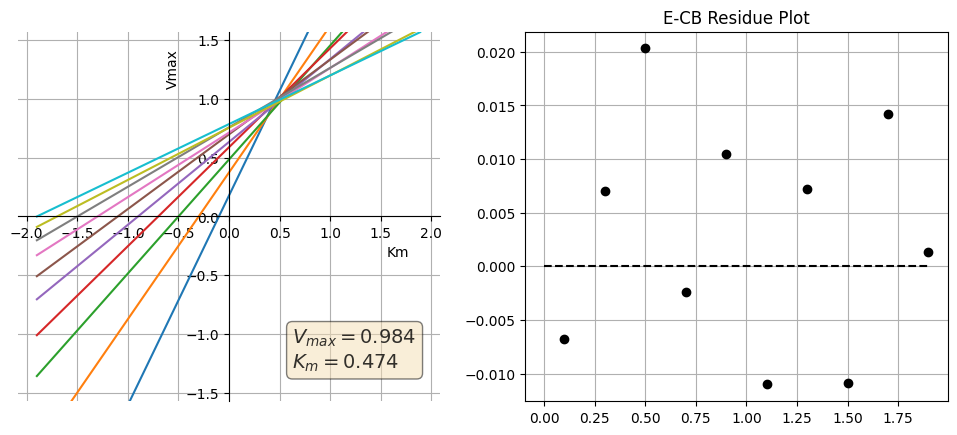

In [141]:
# Eisenthal Cornish-Bowden direct linear plot
x = np.arange(-s.max(),s.max(),0.01)
int_Vmax = []
int_Km = []
mmlines = np.vstack((vm/s,vm)).T
n_int = len(s)*(len(s)-1)//2
#Km_int = np.zeros(n_int)
#Vmax_int = np.zeros(n_int)

fig = plt.figure()
fig.set_figwidth(12)
plt.subplot(121)
for m, b in mmlines:
  plt.plot(x,m*x+b)

print("Computing {:d} intersections".format(n_int))
for i in range(mmlines.shape[0]):
  for j in range(i):
    m1, b1 = mmlines[i]
    m2, b2 = mmlines[j]
    x = (b2-b1)/(m1-m2)
    y = (b2*m1-b1*m2)/(m1-m2)
    int_Km.append(x)
    int_Vmax.append(y)
    #print(x,y)
    #pass
    #print(i,j,mmlines[i],mmlines[j])rray python

ax = plt.gca()
ax.axis([-1.1*s.max(),1.1*s.max(),-2*vm.max(),2*vm.max()])
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlabel("Km",x=0.9)
ax.set_ylabel("Vmax",y=0.9)


# Remove zeros on x an y axis
#import matplotlib.ticker as ticker
#func = lambda x, pos: "" if np.isclose(x,0) else x
#ax.xaxis.set_major_formatter(ticker.FuncFormatter(func))
#ax.yaxis.set_major_formatter(ticker.FuncFormatter(func))

ECB_Km = np.median(int_Km)
ECB_Vmax = np.median(int_Vmax)
v_hat = MM(ECB_Km, ECB_Vmax, s)
# Place a box with the estimates
textstr = '\n'.join((
    r'$V_{max}=%.3g$' % (ECB_Vmax, ),
    r'$K_m=%.3g$' % (ECB_Km, ))) 
    #r'$\sigma=%.2f$' % (sigma, ))))
# place a text box in lower left in axes coords
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.65, 0.20, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props,alpha=0.8)


plt.subplot(122)
_ = plt.title("E-CB Residue Plot")
_ = plt.hlines(0,0, s[-1],linestyles='dashed')
plt.plot(s,v_hat-vm,'ko')

print("Direct Linear plot estimates:") 
print("    Km = {:5.3f}, Vmax= {:5.3f}".format(ECB_Km, ECB_Vmax))
df_estimates['E-CB'] = ECB_Km, ECB_Vmax

##### Non-Linear Regression methods

Exact non-linear estimates at constant relative error:
    Km = 0.459, Vmax= 0.970


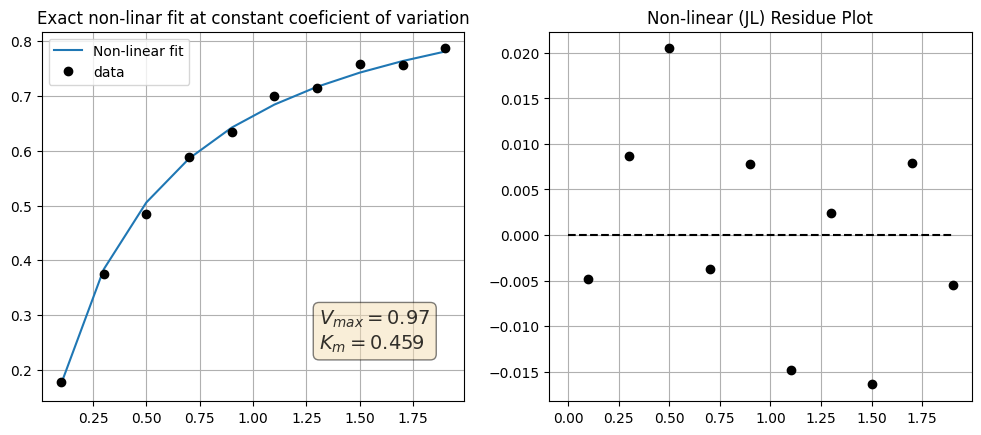

In [142]:
# Non-linear least square fitting (constant relative error)
# Johansen and Lumry
D = (vm*vm / s / s).sum()*vm.sum()-(vm*vm/s).sum()*(vm/s).sum()
JL_Vmax = ((vm*vm / s / s).sum()*(vm*vm).sum()-((vm*vm/s).sum())**2) / D
JL_Km = ((vm*vm).sum()*(vm/s).sum()-(vm*vm/s).sum()*vm.sum()) / D
fig = plt.figure()
fig.set_figwidth(12)
plt.subplot(121)
_ = plt.title("Exact non-linar fit at constant coeficient of variation")
plt.plot(s,MM(JL_Km,JL_Vmax,s),label = "Non-linear fit")
plt.plot(s,vm, 'ko', label='data')
plt.legend()

# Place a box with the estimates
textstr = '\n'.join((
    r'$V_{max}=%.3g$' % (JL_Vmax, ),
    r'$K_m=%.3g$' % (JL_Km, ))) 
    #r'$\sigma=%.2f$' % (sigma, ))))
# place a text box in lower left in axes coords
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.40, 0.20, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props,alpha=0.8)



plt.subplot(122)
_ = plt.title("Non-linear (JL) Residue Plot")
_ = plt.hlines(0,0, s[-1],linestyles='dashed')
v_hat = MM(JL_Km, JL_Vmax, s)
plt.plot(s,v_hat-vm,'ko')
print("Exact non-linear estimates at constant relative error:")
print("    Km = {:5.3f}, Vmax= {:5.3f}".format(JL_Km, JL_Vmax))
df_estimates['JL'] = JL_Km, JL_Vmax

Exact non-linear estimates at constant relative error:
    Km = 0.490, Vmax= 0.990


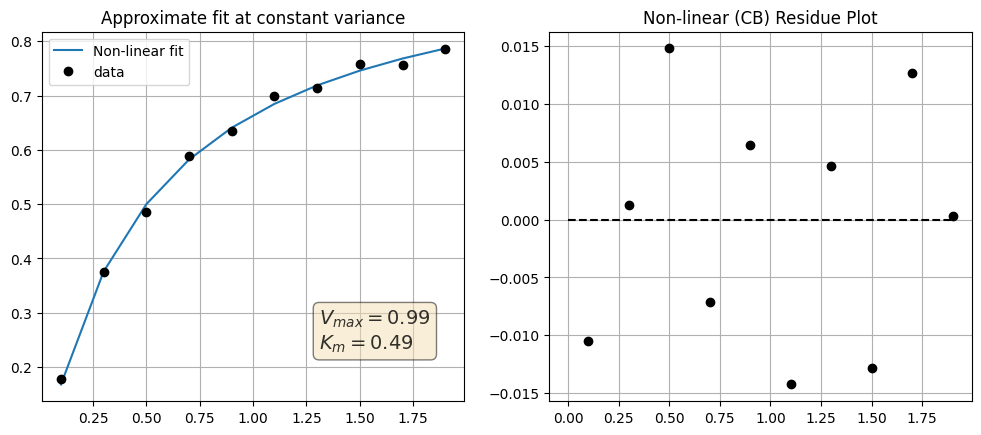

In [143]:
# Non-linear least square fitting (constant variance)
# Cornish-Bowden

v_hat = np.copy(vm)  # initial estimates
de = 1
while de > 1.0e-5:
    D = ((v_hat**3)*vm / s / s).sum()*(v_hat**3).sum() - \
    ((vm*v_hat**3)/s).sum()*((v_hat**3)/s).sum()
    CB_Vmax = ((v_hat**3)*vm / s / s).sum() * \
            (vm*v_hat**3).sum()-(((vm*v_hat**3)/s).sum())**2
    CB_Km = (vm*v_hat**3).sum()*(v_hat**3/s).sum() - \
            (vm*v_hat**3/s).sum() * (v_hat**3).sum()
    CB_Vmax /= D
    CB_Km /= D
    #print("Exact non-linear estimates at constant relative error:")
    #print("    Km = {:5.3f}, Vmax= {:5.3f}".format(JL_Km, JL_Vmax))
    ov_hat = v_hat
    v_hat = MM(CB_Km, CB_Vmax, s)
    de = np.linalg.norm(v_hat - ov_hat)
    #print("---> ", Km_hat, Vmax_hat)
    # print(de)

fig = plt.figure()
fig.set_figwidth(12)
plt.subplot(121)
_ = plt.title("Approximate fit at constant variance")
plt.plot(s, MM(CB_Km, CB_Vmax, s),label = "Non-linear fit")
plt.plot(s, vm, 'ko', label='data')
plt.legend()

# Place a box with the estimates
textstr = '\n'.join((
    r'$V_{max}=%.3g$' % (CB_Vmax, ),
    r'$K_m=%.3g$' % (CB_Km, ))) 
    #r'$\sigma=%.2f$' % (sigma, ))))
# place a text box in lower left in axes coords
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.40, 0.20, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props,alpha=0.8)


plt.subplot(122)
v_hat = MM(CB_Km, CB_Vmax, s)
_ = plt.title("Non-linear (CB) Residue Plot")
_ = plt.hlines(0,0, s[-1],linestyles='dashed')
plt.plot(s,v_hat-vm,'ko')
print("Exact non-linear estimates at constant relative error:")
print("    Km = {:5.3f}, Vmax= {:5.3f}".format(CB_Km, CB_Vmax))
df_estimates['CB'] = CB_Km, CB_Vmax

In [144]:
df_estimates

,L-B,H-W,E-CB,JL,CB
Km,0.434,0.476,0.474,0.459,0.49
Vmax,0.946,0.982,0.984,0.97,0.99
